<a href="https://colab.research.google.com/github/Osujan/MLTSA25_SShrestha/blob/main/HW4/PLAsTICC_GP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023).

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes.



In [89]:
import pandas as pd
import numpy as np
import pylab as pl
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import statsmodels.api as sm

%pylab inline



Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018

 The data on zenodo seems to be broken
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ

 You are only interested in the dataset called _plasticc_train_lightcurves.csv.gz_ and the correspondingn metadata _plasticc_train_metadata.csv.gz_ (note: metadata literally means data about the data)
 or if you get data from Kaggle (preferred) called
 _training_set.csv_ and _training_set_metadata.csv_

 The data is also in my drive at the link https://drive.google.com/file/d/1-M_xvSnZG0x26vsOPU4fS9HX3KQNu3y7/view?usp=sharing - from this name you can figure out how to read the data in with the package gdown.

**Preferred**: you can get the data from kaggle as (mind you, it will take some time! after downloading you want to _unzip_ the data)

`!kaggle competitions download -c PLAsTiCC-2018`

but you need to agree to the terms of competition first
https://www.kaggle.com/settings

In [90]:
!pip install kaggle

In [91]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [92]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [93]:
ls kaggle.json

kaggle.json


In [94]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [95]:
cd /content/gdrive/MyDrive/MLTSA25

/content/gdrive/MyDrive/MLTSA25


In [96]:
!mkdir HW4

mkdir: cannot create directory ‘HW4’: File exists


In [97]:
cd HW4

/content/gdrive/MyDrive/MLTSA25/HW4


In [98]:
!kaggle competitions download -c PLAsTiCC-2018

PLAsTiCC-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [99]:
!ls

data_note.pdf	       test_set_batch11.csv  test_set.csv	    training_set_metadata.csv
PLAsTiCC-2018.zip      test_set_batch1.csv   test_set_metadata.csv
sample_submission.csv  test_set_batch2.csv   test_set_sample.csv
test_set_batch10.csv   test_set_batch3.csv   training_set.csv


In [100]:
#!unzip PLAsTiCC-2018.zip

In [101]:
lcvs = pd.read_csv('training_set.csv')

In [102]:
lcvs.head()

object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1

In [103]:
lcvs.tail()

object_id         mjd  passband       flux   flux_err  detected
1421700  130779836  60555.9838         4 -39.881969  46.477093         0
1421701  130779836  60560.0459         1  14.894439  18.947685         0
1421702  130779836  60571.0225         5  30.593130  50.695290         0
1421703  130779836  60585.9974         4 -23.471439  44.819859         0
1421704  130779836  60588.0372         0 -41.214264  51.665123         0

In [104]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [105]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands: those are different wavelength ranges over which we observe light (e.g. r is roughtly the wavelengths corresponding to the red portion of the rainbow)

In [106]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [107]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [108]:
metadata = pd.read_csv('training_set_metadata.csv')
metadata.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

In [109]:
metadata.tail()

object_id          ra       decl       gal_l      gal_b  ddf  \
7843  130739978   26.718750 -14.940303  172.342697 -72.255675    0   
7844  130755807  120.101349 -62.696659  275.742955 -16.509746    0   
7845  130762946  203.108109 -55.682144  308.728904   6.727511    0   
7846  130772921   79.101562 -35.501846  239.172243 -33.827844    0   
7847  130779836  301.992188 -17.426323   25.102988 -24.511101    0   

      hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
7843         0.0000          0.0000              0.0000      NaN  0.013   
7844         0.1725          2.5606              1.1146  46.6108  0.136   
7845         0.0000          0.0000              0.0000      NaN  0.430   
7846         0.0000          0.0000              0.0000      NaN  0.034   
7847         0.0000          0.0000              0.0000      NaN  0.091   

      target  
7843      65  
7844      90  
7845      16  
7846      65  
7847       6

In [110]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [111]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series
Visualize my data to get a sense of what we are working with.





Plot light curves for 10 objects.

In [112]:
objects

array([      615,       713,       730, ..., 130762946, 130772921,
       130779836])

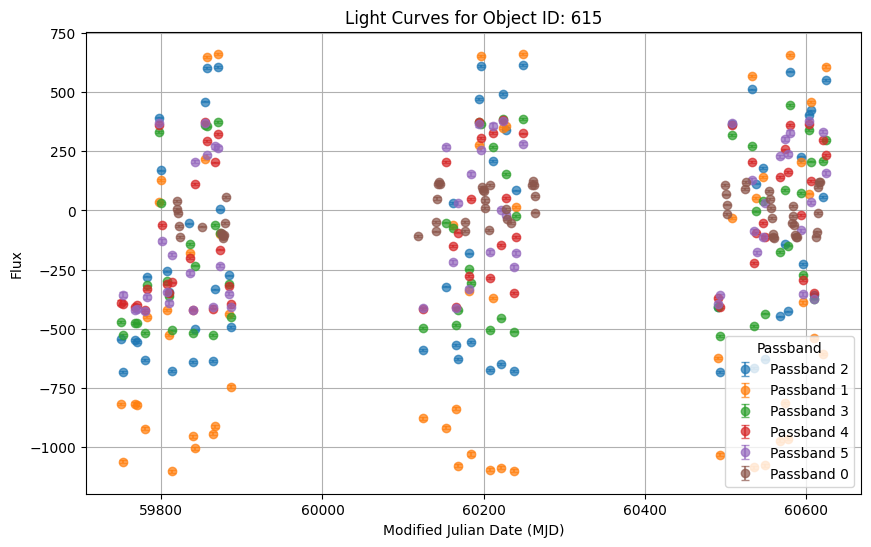

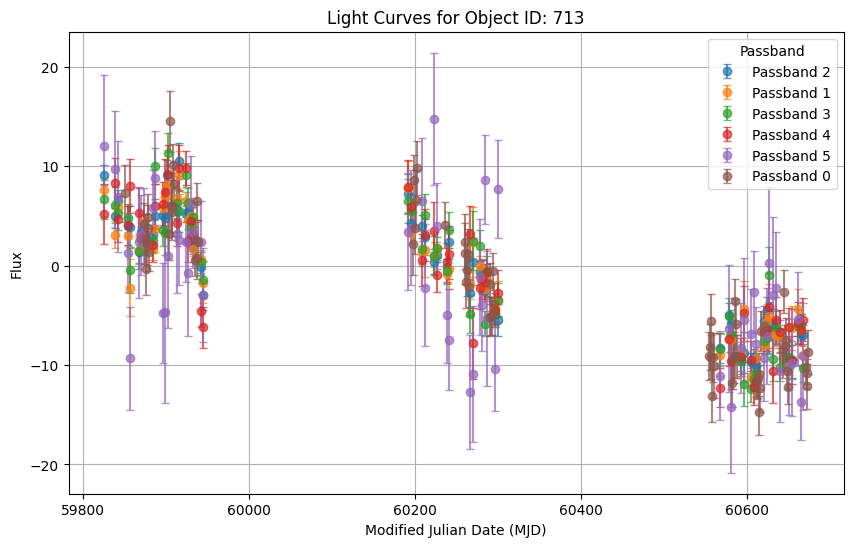

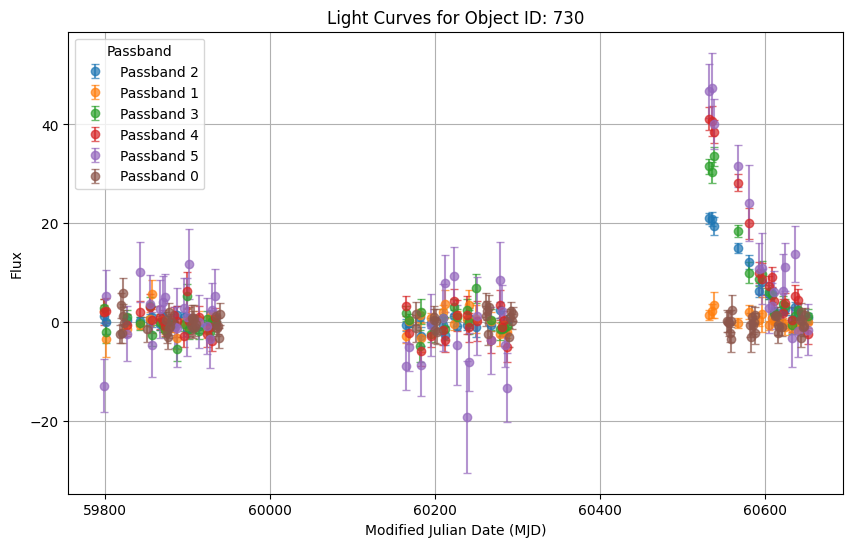

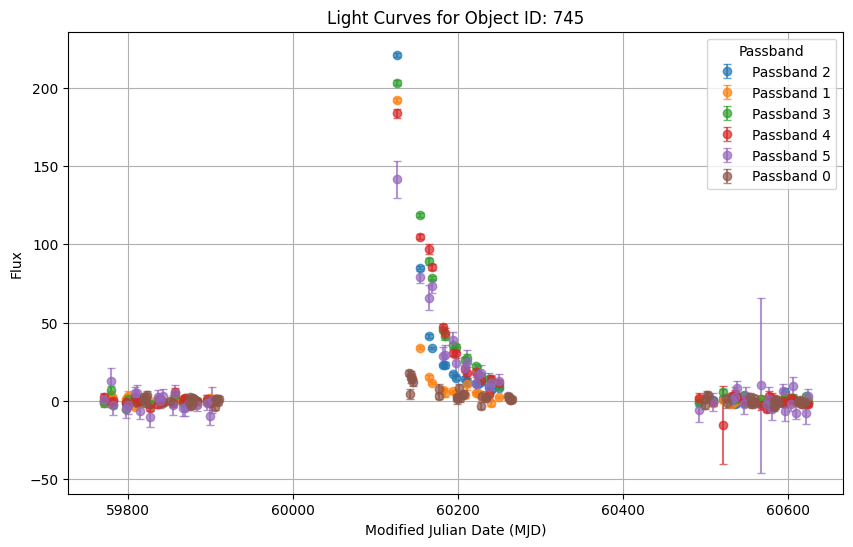

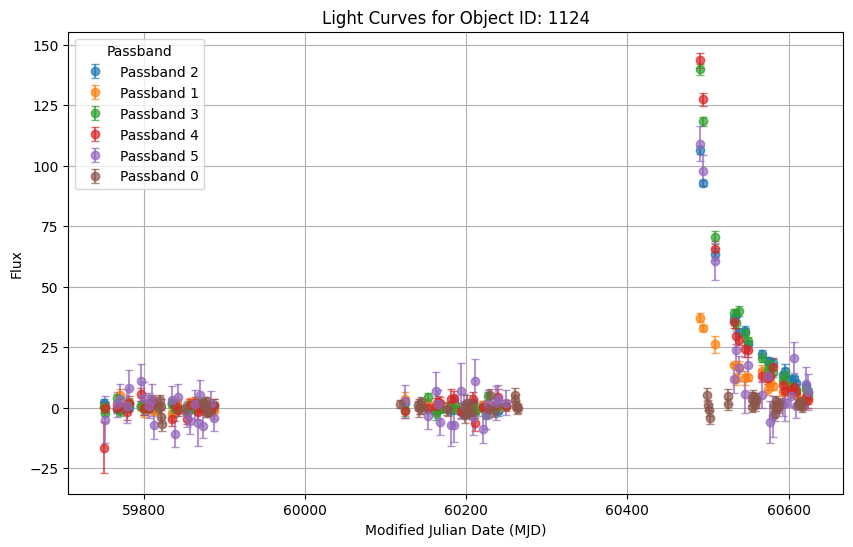

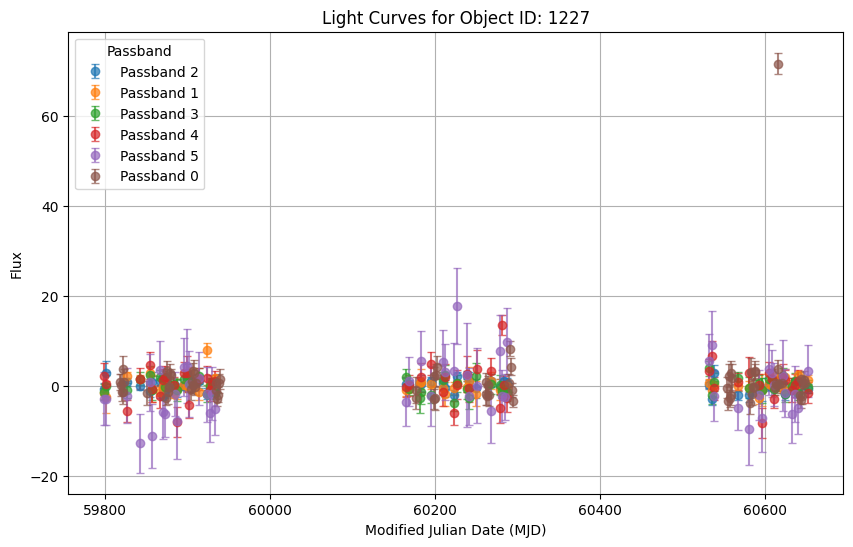

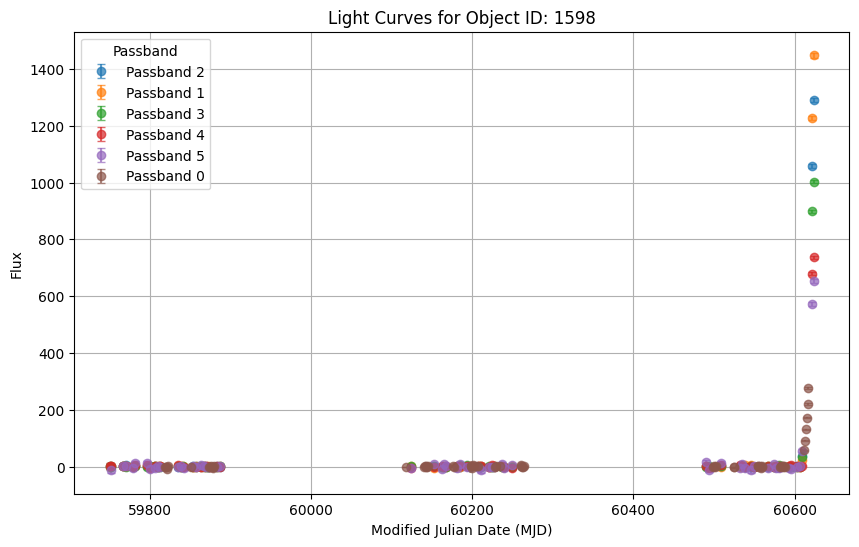

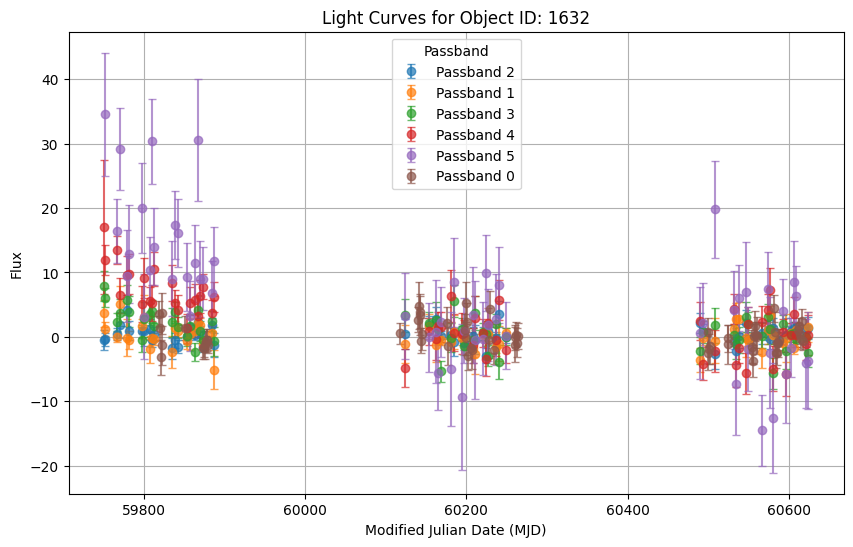

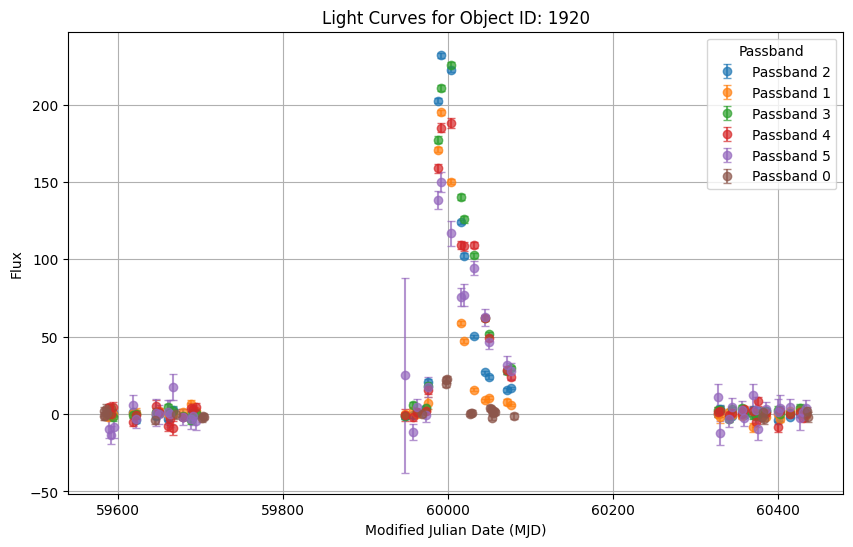

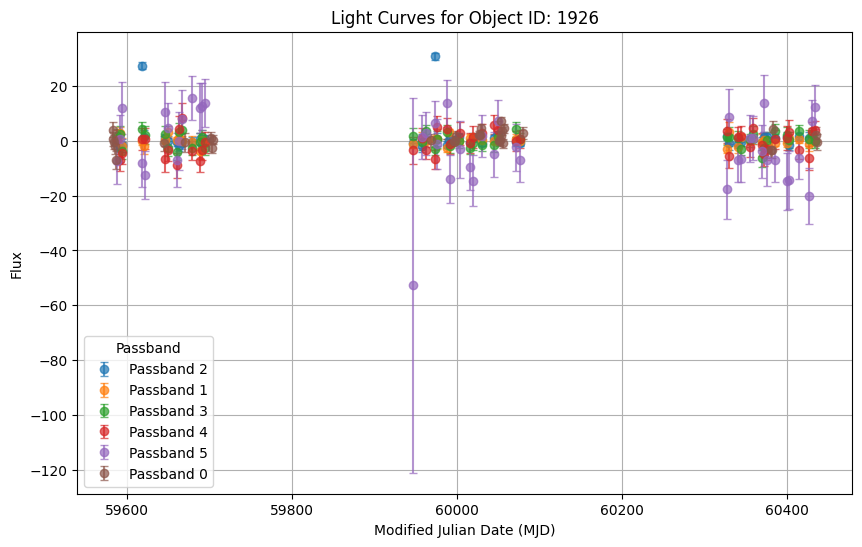

In [113]:
# prompt: make this plot scatter plot

import matplotlib.pyplot as plt

# Assuming 'lcvs' DataFrame is already loaded as in the previous code

for obj_id in objects[:10]:  # Iterate through the first 10 objects
    obj_data = lcvs[lcvs["object_id"] == obj_id]
    plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
    for band in bands:
        band_data = obj_data[obj_data["passband"] == band]
        #plt.scatter(band_data["mjd"], band_data["flux"], label=f"Passband {band}")

        plt.errorbar(band_data['mjd'], band_data['flux'], yerr=band_data['flux_err'],
                     fmt='o', label=f'Passband {band}', alpha=0.7, capsize=3)
    plt.title(f"Light Curves for Object ID: {obj_id}")
    plt.xlabel("Modified Julian Date (MJD)")
    plt.ylabel("Flux")
    plt.legend(title = "Passband")
    plt.grid(True)
    plt.show()


YOUR CODE HERE...

Plot explicitly object 84716

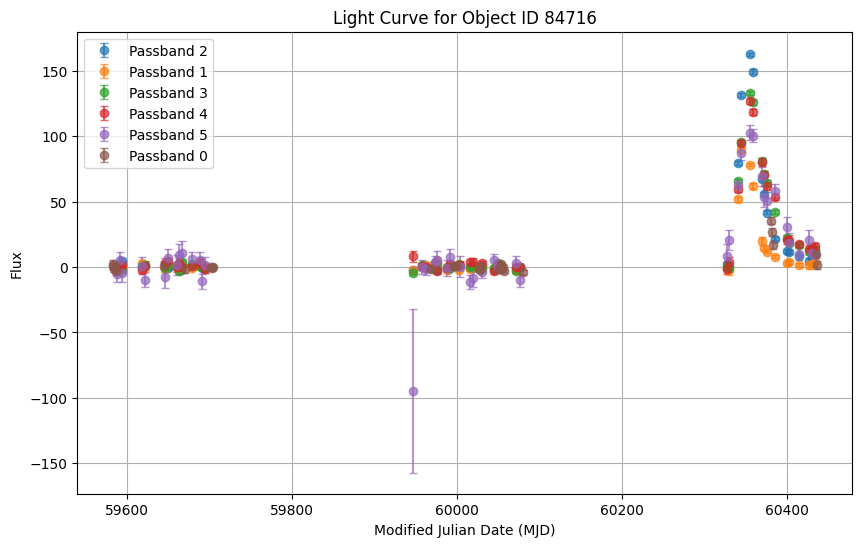

In [114]:
# Filter the light curves DataFrame for object ID 84716
obj_lc = lcvs[lcvs["object_id"] == 84716]
plt.figure(figsize=(10, 6))
# Plot the light curve for each passband
for band in bands:
    band_lc = obj_lc[obj_lc["passband"] == band]
    if not band_lc.empty:
        #pl.plot(band_lc["mjd"], band_lc["flux"], label=f"Passband {band}")
         plt.errorbar(band_lc['mjd'], band_lc['flux'], yerr=band_lc['flux_err'],
                     fmt='o', label=f'Passband {band}', alpha=0.7, capsize=3)

pl.xlabel("Modified Julian Date (MJD)")
pl.ylabel("Flux")
pl.title(f"Light Curve for Object ID 84716")
pl.legend()
plt.grid(True)
pl.show()

YOUR CODE HERE

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**:
    - mean,
    - standard deviation,
    - skewness,
    - kurthosis,
    - minimum
    - maximmum,
    - error on the minimum and
    - error on the maximum,
- **from the standardized lightcurve**:
    - median
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data!
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready.
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar.


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve -


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [115]:
import scipy.stats as st

def moments(x):
    return [np.mean(x), np.std(x), st.skew(x), st.kurtosis(x), np.min(x), np.max(x)]

def error_on_min_max(group): #Pass the entire group instead of individual columns
    min_idx = group['flux'].idxmin() #Get index of minimum flux
    max_idx = group['flux'].idxmax() #Get index of maximum flux

    # Use .loc to access values by index, ensuring alignment
    min_err = group.loc[min_idx, 'flux_err']
    max_err = group.loc[max_idx, 'flux_err']

    return [min_err, max_err]

# Apply feature extraction to each object and passband
features = lcvs.groupby(['object_id', 'passband']).agg(
    mean=('flux', 'mean'),
    std=('flux', 'std'),
    skew=('flux', lambda x: st.skew(x)),
    kurt=('flux', lambda x: st.kurtosis(x)),
    min=('flux', 'min'),
    max=('flux', 'max')
)


#Calculate errors on min and max
# Pass the entire group to error_on_min_max
min_max_errors = lcvs.groupby(['object_id', 'passband']).apply(error_on_min_max)
min_max_errors = pd.DataFrame(min_max_errors.values.tolist(), index=min_max_errors.index, columns=['min_flux_err', 'max_flux_err'])

#Combine with other features
features = features.join(min_max_errors)


print(features.head(20))

                          mean         std      skew       kurt          min  \
object_id passband                                                             
615       0          -3.254554   83.944735  0.125827  -1.454426  -116.913223   
          1        -385.699911  601.787302  0.404755  -1.251198 -1100.440063   
          2        -134.146566  455.121346  0.331063  -1.392937  -681.858887   
          3        -121.103501  335.425053  0.285492  -1.429545  -530.644592   
          4         -55.954592  291.803449  0.194883  -1.519722  -422.184509   
          5         -47.449847  294.779522  0.121948  -1.559937  -422.815094   
713       0          -2.720398    7.113509  0.254446  -1.027516   -14.735178   
          1          -1.019804    5.712334 -0.085494  -1.106890   -11.715749   
          2          -0.794238    5.770738 -0.022066  -1.190242   -10.067919   
          3          -0.986966    6.450413 -0.162664  -1.148634   -12.394593   
          4          -0.900262    6.4069

<ipython-input-115-243f7f25a5b5>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_max_errors = lcvs.groupby(['object_id', 'passband']).apply(error_on_min_max)


In [116]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 48)

In [117]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

passband          0                                                         \
               mean        std      skew      kurt         min         max   
object_id                                                                    
615       -3.254554  83.944735  0.125827 -1.454426 -116.913223  125.182808   
713       -2.720398   7.113509  0.254446 -1.027516  -14.735178   14.509829   
730       -0.048080   1.828872  0.349431  0.359725   -3.459960    5.942166   
745        1.797523   4.374445  1.980815  4.232286   -3.874349   18.014029   
1124       0.660948   2.360084 -0.324207  0.664903   -6.804703    5.330927   

passband                                      1              ...            4  \
          min_flux_err max_flux_err        mean         std  ... min_flux_err   
object_id                                                    ...                
615           3.097836     3.909554 -385.699911  601.787302  ...     4.089213   
713           2.326417     3.098125   -1.019804    5.712334  ...     1.978125   
730           2.511074     2.901580    0.141057    1.807229  ...     3.003132   
745           1.722069     1.878526    5.717394   25.964659  ...    24.753073   
1124          3.029140     2.713767    4.634637    8.107525  ...    10.423373   

passband                        5                                   \
          max_flux_err       mean         std      skew       kurt   
object_id                                                            
615           3.885009 -47.449847  294.779522  0.121948  -1.559937   
713           2.274502  -1.794175    7.094073  0.212294  -0.832902   
730           2.310168   4.539396   13.332758  1.630520   3.125970   
745           2.818825  10.746138   26.060130  3.083716  10.952063   
1124          3.106449   6.896742   21.434627  3.560347  13.095559   

passband                                                     
                  min         max min_flux_err max_flux_err  
object_id                                                    
615       -422.815094  378.188141     8.124096     6.295821  
713        -14.211164   14.770886     6.624023     6.656366  
730        -19.159811   47.310059    11.281384     7.197146  
745        -10.249387  141.513290     6.671597    11.663839  
1124       -10.860540  109.157585     5.269359     7.225436  

[5 rows x 48 columns]

Even with the same standard deviation two distribution can be very different.
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation).


Standardize the lcvs and extract some features from the raw lightcurve -


In [118]:
from sklearn import preprocessing

# Assuming 'lcvs' DataFrame is already loaded and processed as in the previous code.

# Standardize flux
lcvs['flux_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux'].transform(preprocessing.scale)

# Standardize flux errors
lcvs['flux_err_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux_err'].transform(lambda x: preprocessing.scale(x))

# Create a new DataFrame with the standardized features
lcvs_scaled = lcvs[['object_id', 'mjd', 'passband', 'flux_scaled', 'flux_err_scaled']].copy()

You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [119]:
#Checking to make sure the scaling worked.
mean_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].mean()
std_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].std()

'''
print("Mean:", mean_norm)
print("Standard Deviation:", std_norm)
'''
mean_norm.head()
std_norm.head()
lcvs_scaled.head()

object_id         mjd  passband  flux_scaled  flux_err_scaled
0        615  59750.4229         2    -0.910198         0.422316
1        615  59750.4306         1    -0.722010         0.452984
2        615  59750.4383         3    -1.053414         1.338867
3        615  59750.4450         4    -1.151251         7.037395
4        615  59752.4070         2    -1.213953         1.150246

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



In [120]:
# prompt: parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits

import pandas as pd
# Group data by object and passband
grouped = lcvs_scaled.groupby(['object_id', 'passband'])
grouped2 = lcvs.groupby(['object_id', 'passband'])
# Function to fit a line and extract features
def fit_line(group):
  '''
  Fits a line to the light curve and extracts the slope.
  Inputs:
    group: the id and passband group
  Outputs:
    slope: the slope of the line fit
  '''
  x = group['mjd'].values
  y = group['flux_scaled'].values
  X = sm.add_constant(x)
  model = sm.OLS(y, X).fit()
  return pd.Series({
      'slope': model.params[1],

    })

# Apply the line fitting function to each group
line_fits = grouped.apply(fit_line)
#lf2 = grouped2.apply(fit_line)
# Reset the index to make 'object_id' and 'passband' regular columns
line_fits = line_fits.reset_index()
#lf2 = lf2.reset_index()

# Now lcvs_scaled contains the slope, intercept and R-squared of the linear fit for each object and passband.
line_fits.head(20)
#lf2.head()

<ipython-input-120-09cb33264753>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  line_fits = grouped.apply(fit_line)


object_id  passband     slope
0         615         0  0.000528
1         615         1  0.000564
2         615         2  0.000756
3         615         3  0.000916
4         615         4  0.001046
5         615         5  0.001012
6         713         0 -0.002880
7         713         1 -0.002824
8         713         2 -0.002861
9         713         3 -0.002773
10        713         4 -0.002706
11        713         5 -0.001996
12        730         0 -0.000122
13        730         1  0.000341
14        730         2  0.001740
15        730         3  0.001593
16        730         4  0.001492
17        730         5  0.001271
18        745         0 -0.000705
19        745         1 -0.000093

the goodness of fit for these models is also a potential feature

#Extracting feature from the metadata

In [121]:
lmeta = pd.read_csv("training_set_metadata.csv")
lmeta.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

In [122]:
declCol = lmeta["decl"]
declCol.head()

#this represents the position in the sky.
#Can help determine if the phenomena is a galactic or extragalactic object

0   -61.943836
1   -27.784405
2    -6.579593
3   -45.586655
4   -63.823658
Name: decl, dtype: float64

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [123]:
#example

#example
features = features.reset_index() # Reset the index of the features DataFrame
line_fits = line_fits.reset_index() # Reset the index of the line_fits DataFrame
# Assuming both DataFrames have 'object_id' and 'passband' columns:
features = features.merge(line_fits, on=['object_id', 'passband'], how='left')
features = features.merge(declCol, left_on=['object_id'], right_index=True, how='left') # Merge 'declCol' based on index of 'lmeta'
features.head()
features.set_index(['object_id', 'passband'], inplace=True) # Set the index back to 'object_id' and 'passband'
features.head()

mean         std      skew      kurt          min  \
object_id passband                                                            
615       0          -3.254554   83.944735  0.125827 -1.454426  -116.913223   
          1        -385.699911  601.787302  0.404755 -1.251198 -1100.440063   
          2        -134.146566  455.121346  0.331063 -1.392937  -681.858887   
          3        -121.103501  335.425053  0.285492 -1.429545  -530.644592   
          4         -55.954592  291.803449  0.194883 -1.519722  -422.184509   

                           max  min_flux_err  max_flux_err  index     slope  \
object_id passband                                                            
615       0         125.182808      3.097836      3.909554      0  0.000528   
          1         660.626343      6.709106      4.961018      1  0.000564   
          2         611.984558      4.041204      3.908728      2  0.000756   
          3         445.737061      3.672556      3.952905      3  0.000916   
          4         381.953735      4.089213      3.885009      4  0.001046   

                        decl  
object_id passband            
615       0        -28.29155  
          1        -28.29155  
          2        -28.29155  
          3        -28.29155  
          4        -28.29155

In [124]:

# Drop the specified columns
features = features.drop(columns=['object_id_y', 'passband_y'], errors='ignore')
features = features.rename(columns={'object_id_x': 'object_id', 'passband_x': 'passband'})
# Display the updated DataFrame (optional)
features.head()


mean         std      skew      kurt          min  \
object_id passband                                                            
615       0          -3.254554   83.944735  0.125827 -1.454426  -116.913223   
          1        -385.699911  601.787302  0.404755 -1.251198 -1100.440063   
          2        -134.146566  455.121346  0.331063 -1.392937  -681.858887   
          3        -121.103501  335.425053  0.285492 -1.429545  -530.644592   
          4         -55.954592  291.803449  0.194883 -1.519722  -422.184509   

                           max  min_flux_err  max_flux_err  index     slope  \
object_id passband                                                            
615       0         125.182808      3.097836      3.909554      0  0.000528   
          1         660.626343      6.709106      4.961018      1  0.000564   
          2         611.984558      4.041204      3.908728      2  0.000756   
          3         445.737061      3.672556      3.952905      3  0.000916   
          4         381.953735      4.089213      3.885009      4  0.001046   

                        decl  
object_id passband            
615       0        -28.29155  
          1        -28.29155  
          2        -28.29155  
          3        -28.29155  
          4        -28.29155

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id.

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [125]:
features.groupby(["object_id", "passband"]).head()

mean           std      skew       kurt  \
object_id passband                                                   
615       0           -3.254554     83.944735  0.125827  -1.454426   
          1         -385.699911    601.787302  0.404755  -1.251198   
          2         -134.146566    455.121346  0.331063  -1.392937   
          3         -121.103501    335.425053  0.285492  -1.429545   
          4          -55.954592    291.803449  0.194883  -1.519722   
...                         ...           ...       ...        ...   
130779836 1          725.169852   1197.557111  1.565742   0.772541   
          2         2690.360415   6440.422386  3.809603  14.318716   
          3          755.993902   1443.868085  2.377087   4.382117   
          4         3489.185336  11006.766106  4.221177  17.012896   
          5         4151.358875   8687.101173  2.274800   3.629547   

                            min           max  min_flux_err  max_flux_err  \
object_id passband                                                          
615       0         -116.913223    125.182808      3.097836      3.909554   
          1        -1100.440063    660.626343      6.709106      4.961018   
          2         -681.858887    611.984558      4.041204      3.908728   
          3         -530.644592    445.737061      3.672556      3.952905   
          4         -422.184509    381.953735      4.089213      3.885009   
...                         ...           ...           ...           ...   
130779836 1          -34.273514   3320.936279     19.637548     56.901775   
          2          -14.478923  31437.089844     23.485855    362.050262   
          3          -41.850040   4995.144043     26.782366     50.181072   
          4          -72.634567  54982.875000     44.931393    424.749237   
          5          -86.457382  29058.212891     57.588879    210.280746   

                    index     slope      decl  
object_id passband                             
615       0             0  0.000528 -28.29155  
          1             1  0.000564 -28.29155  
          2             2  0.000756 -28.29155  
          3             3  0.000916 -28.29155  
          4             4  0.001046 -28.29155  
...                   ...       ...       ...  
130779836 1         47083 -0.002640       NaN  
          2         47084 -0.001899       NaN  
          3         47085 -0.002363       NaN  
          4         47086 -0.001157       NaN  
          5         47087 -0.001519       NaN  

[47088 rows x 11 columns]

In [126]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 66)

In [127]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

passband          0                                                         \
               mean        std      skew      kurt         min         max   
object_id                                                                    
615       -3.254554  83.944735  0.125827 -1.454426 -116.913223  125.182808   
713       -2.720398   7.113509  0.254446 -1.027516  -14.735178   14.509829   
730       -0.048080   1.828872  0.349431  0.359725   -3.459960    5.942166   
745        1.797523   4.374445  1.980815  4.232286   -3.874349   18.014029   
1124       0.660948   2.360084 -0.324207  0.664903   -6.804703    5.330927   

passband                                             ...           5  \
          min_flux_err max_flux_err index     slope  ...         std   
object_id                                            ...               
615           3.097836     3.909554   0.0  0.000528  ...  294.779522   
713           2.326417     3.098125   6.0 -0.002880  ...    7.094073   
730           2.511074     2.901580  12.0 -0.000122  ...   13.332758   
745           1.722069     1.878526  18.0 -0.000705  ...   26.060130   
1124          3.029140     2.713767  24.0  0.001244  ...   21.434627   

passband                                                             \
               skew       kurt         min         max min_flux_err   
object_id                                                             
615        0.121948  -1.559937 -422.815094  378.188141     8.124096   
713        0.212294  -0.832902  -14.211164   14.770886     6.624023   
730        1.630520   3.125970  -19.159811   47.310059    11.281384   
745        3.083716  10.952063  -10.249387  141.513290     6.671597   
1124       3.560347  13.095559  -10.860540  109.157585     5.269359   

passband                                           
          max_flux_err index     slope       decl  
object_id                                          
615           6.295821   5.0  0.001012 -28.291550  
713           6.656366  11.0 -0.001996   3.583322  
730           7.197146  17.0  0.001271   3.583322  
745          11.663839  23.0  0.000003   2.985506  
1124          7.225436  29.0  0.001120   3.732834  

[5 rows x 66 columns]

what is the shape of your final feature space?

In [128]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 66 features (columns)


Now make histograms for allfeatures to show their distributions

<ipython-input-129-c1e4e36bac4f>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


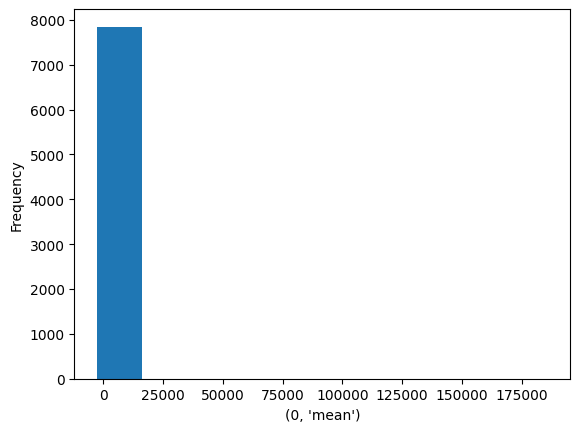

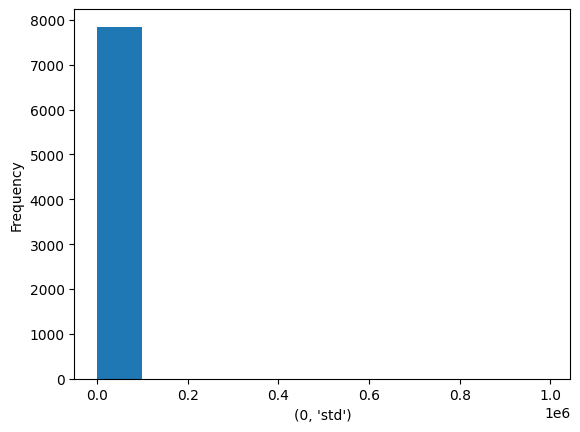

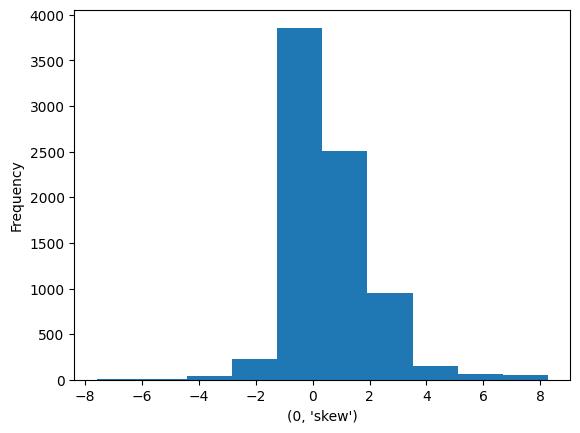

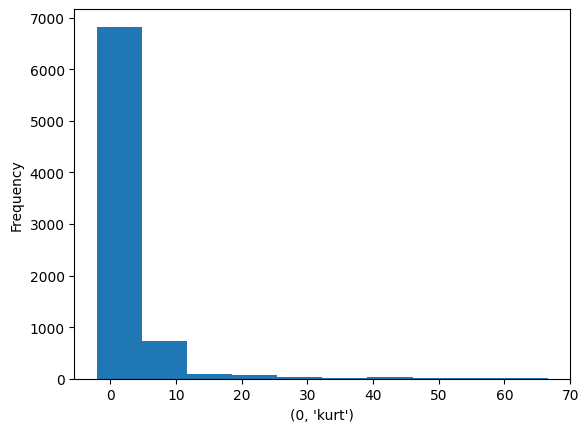

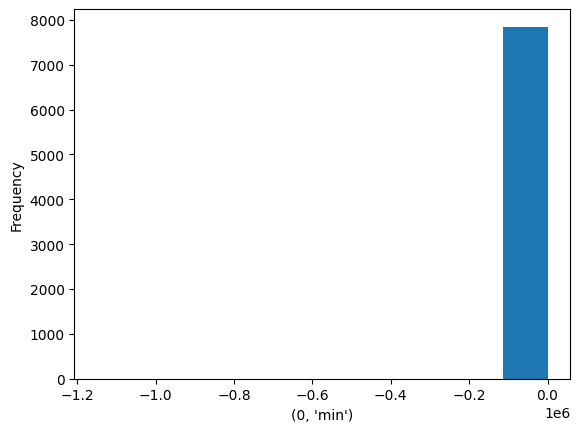

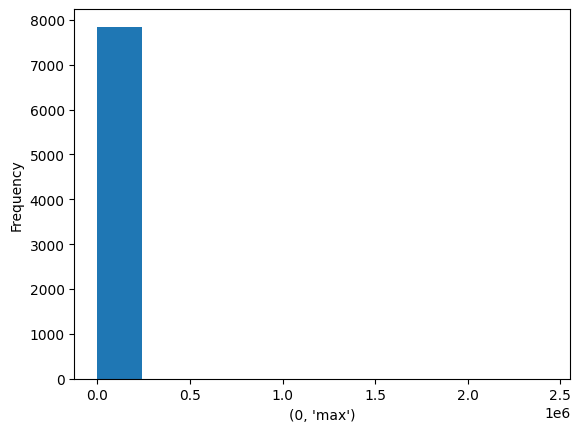

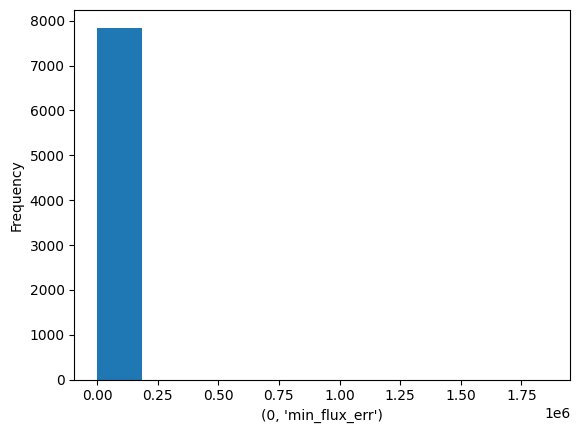

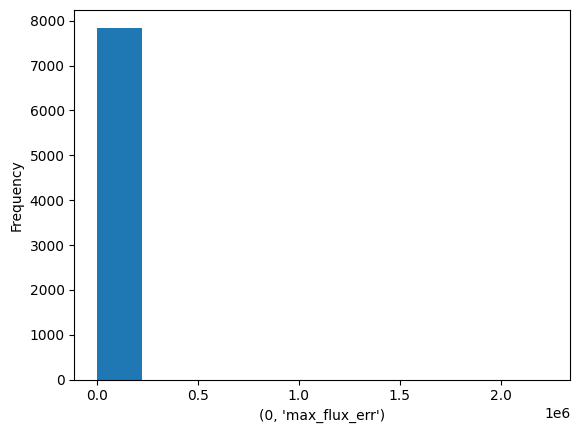

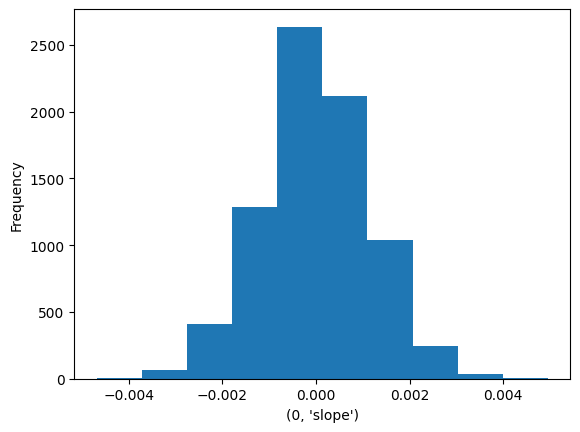

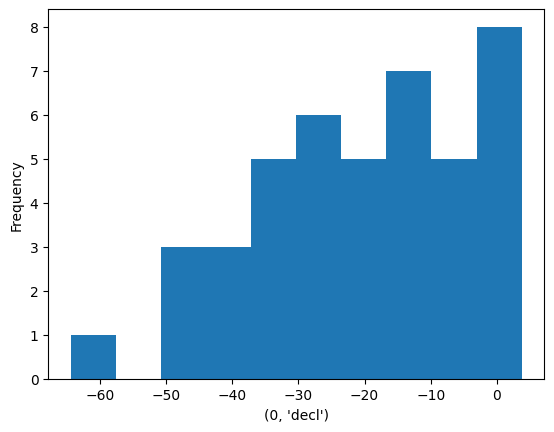

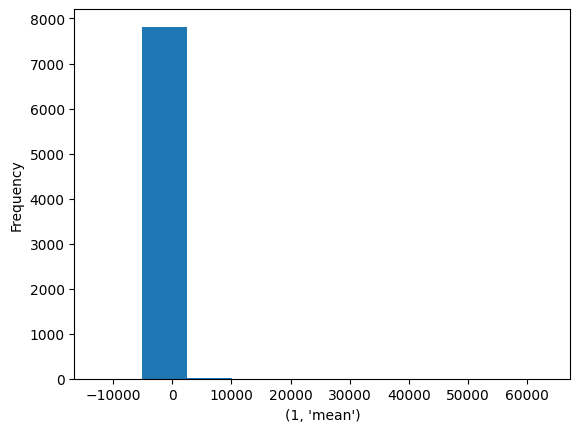

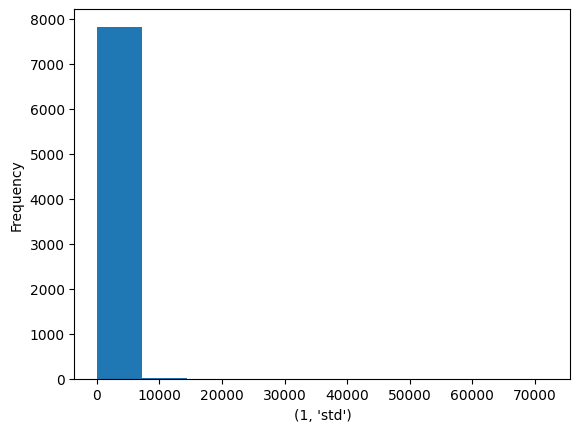

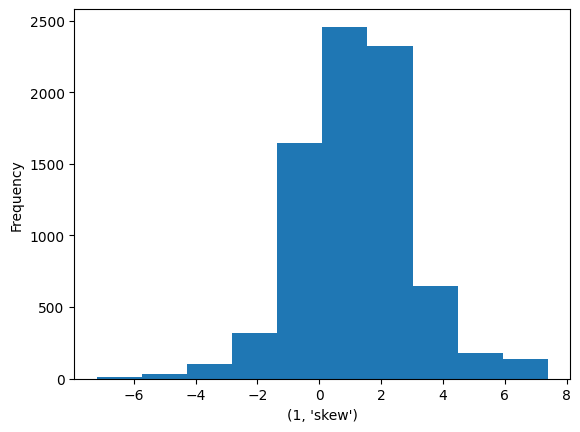

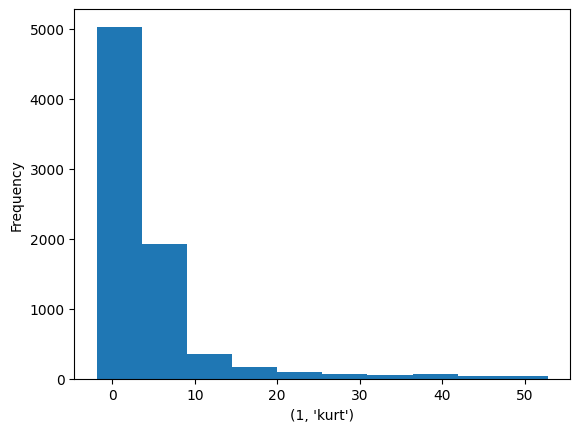

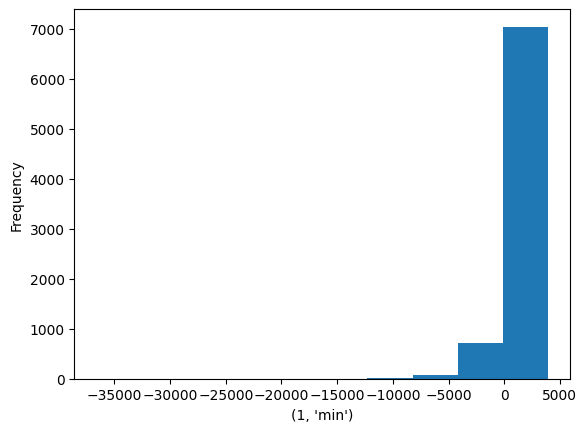

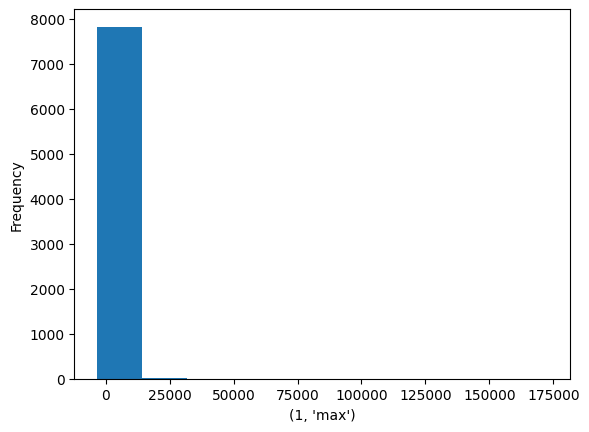

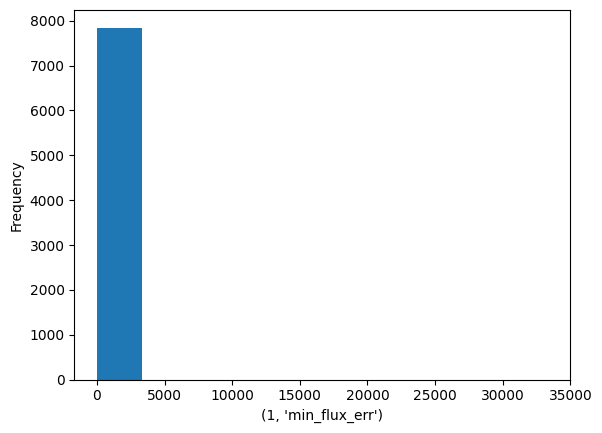

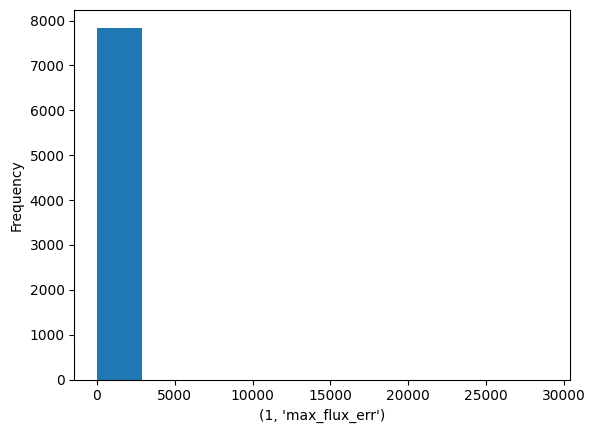

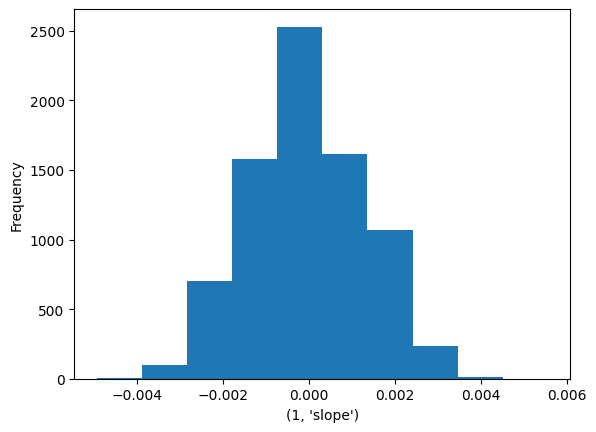

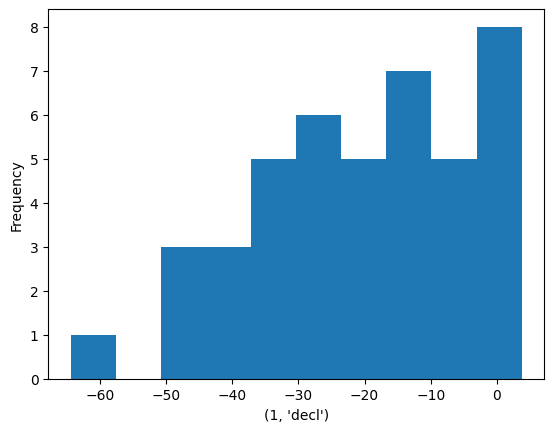

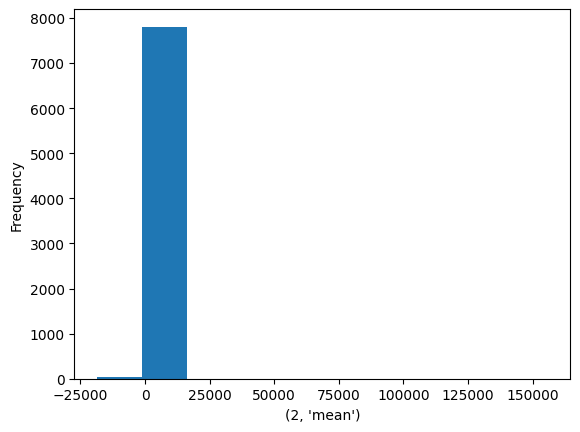

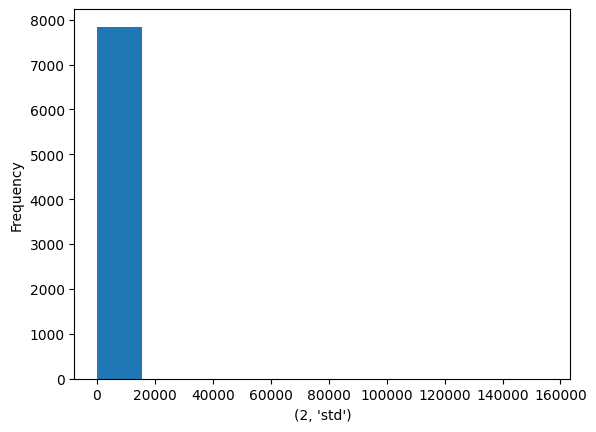

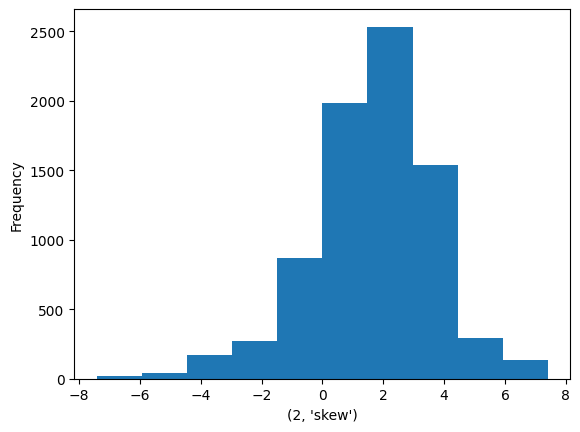

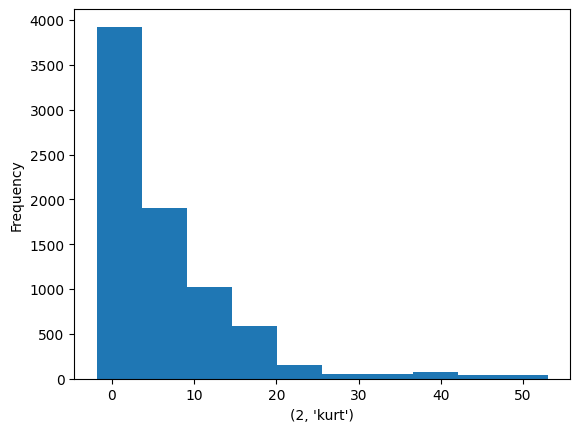

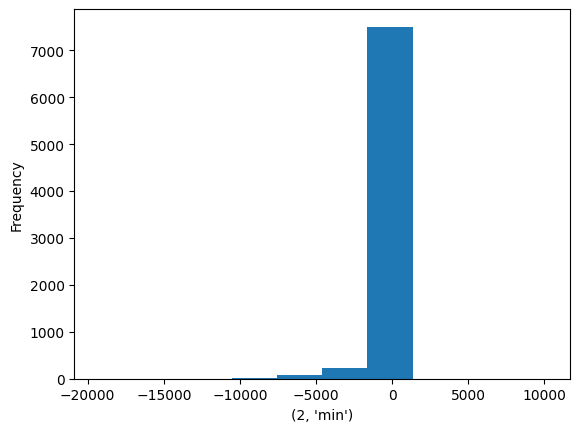

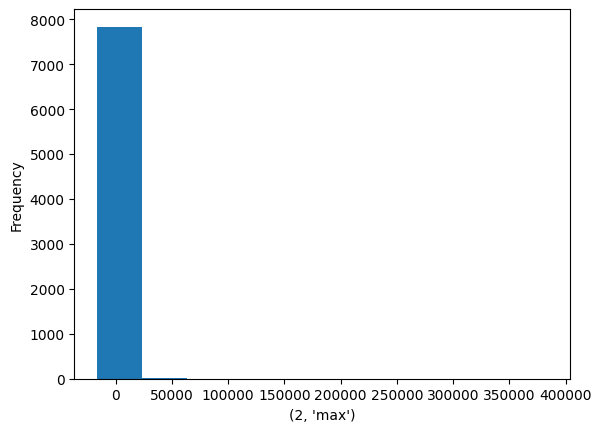

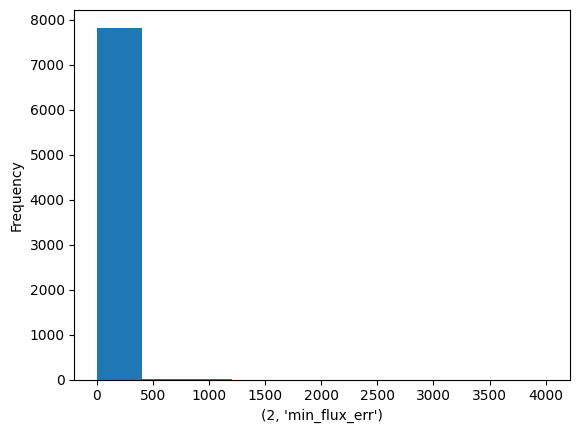

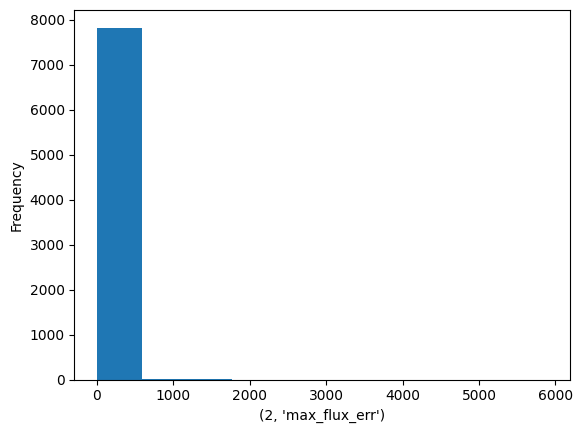

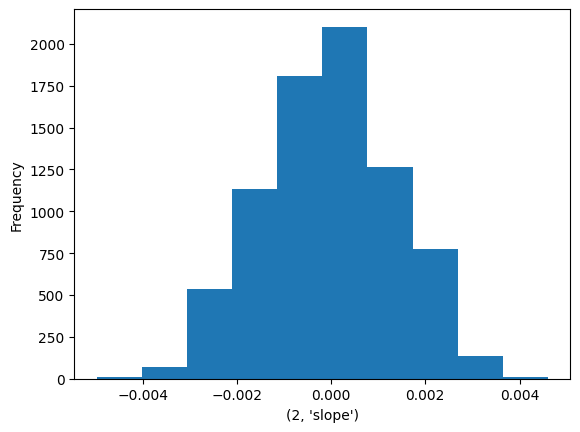

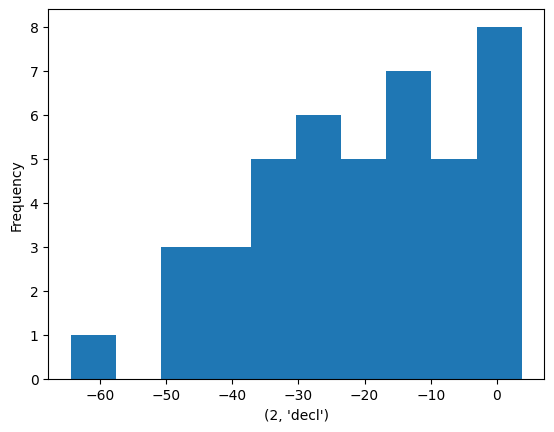

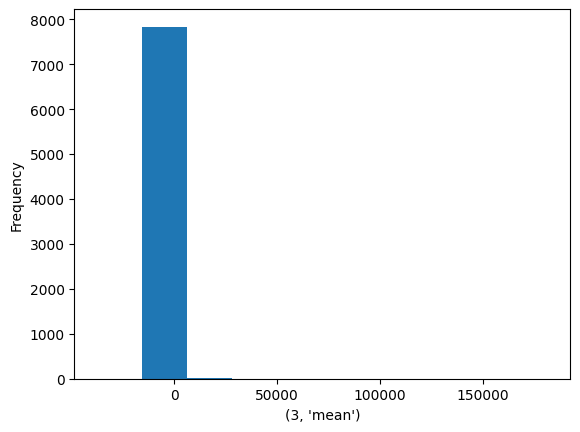

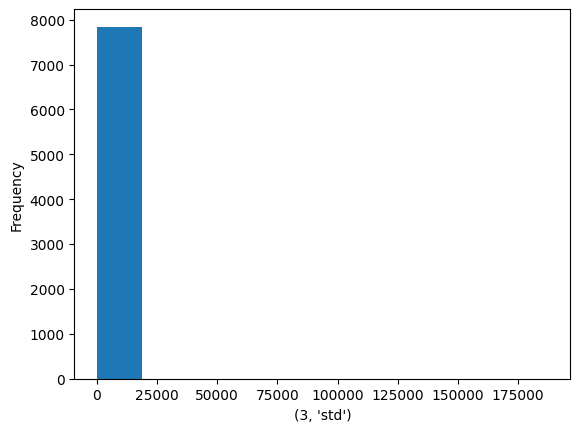

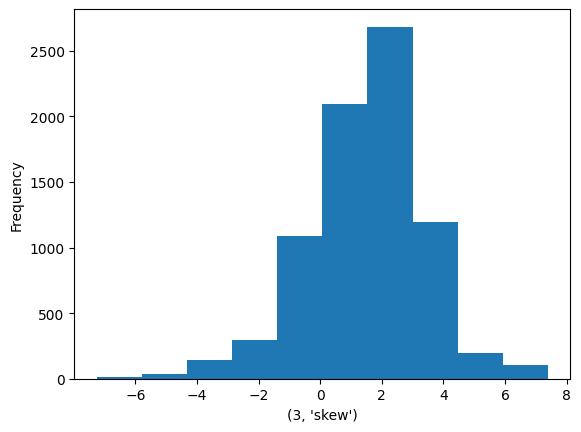

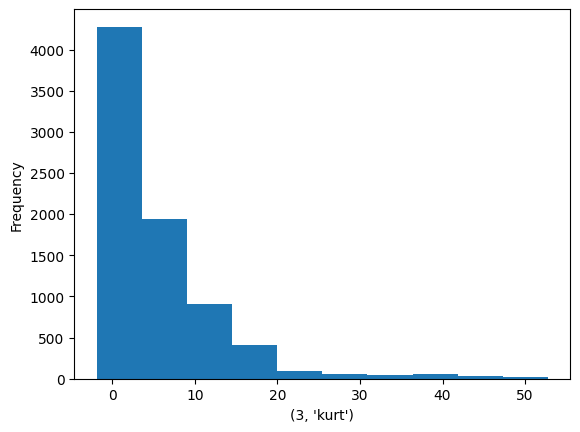

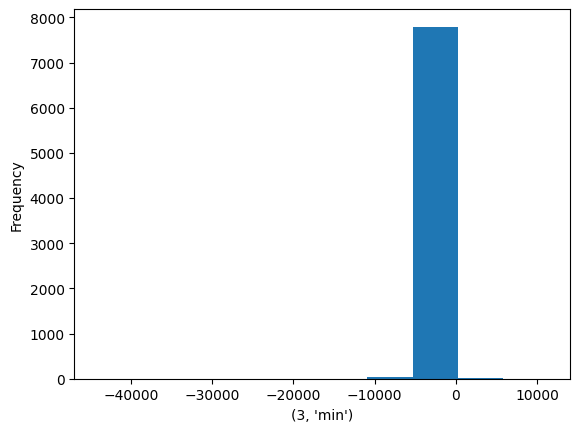

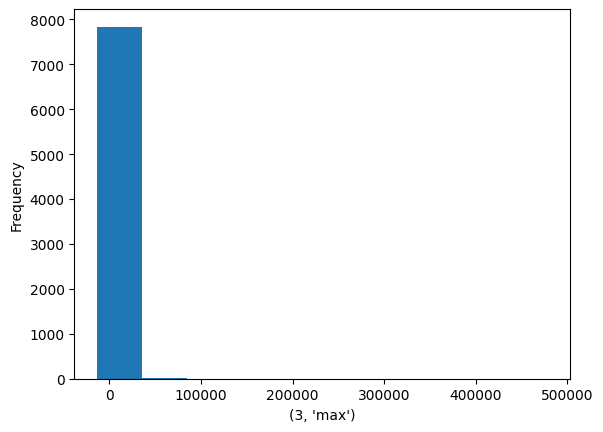

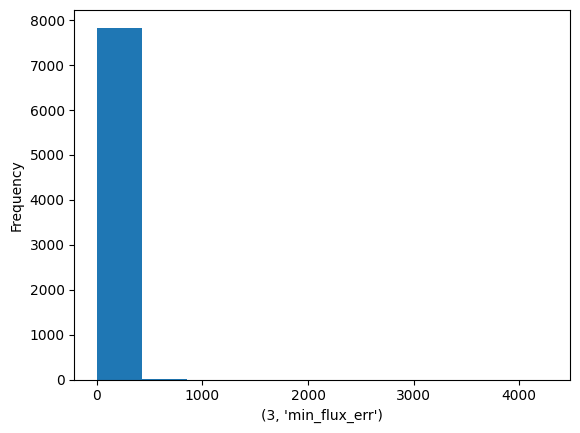

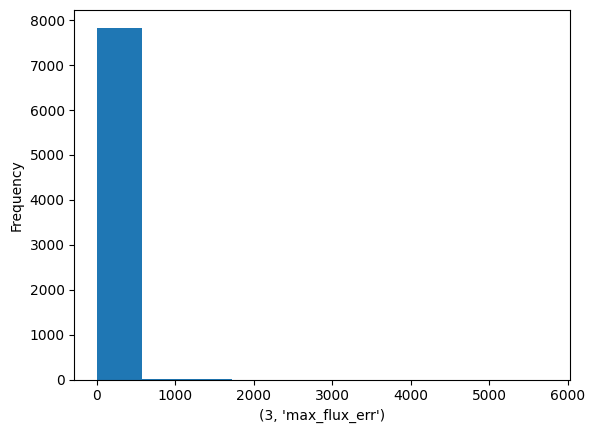

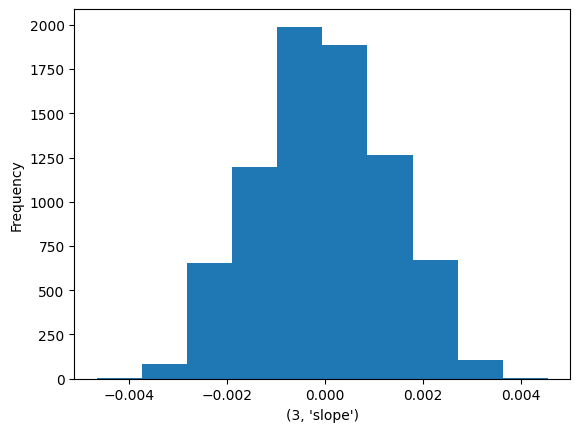

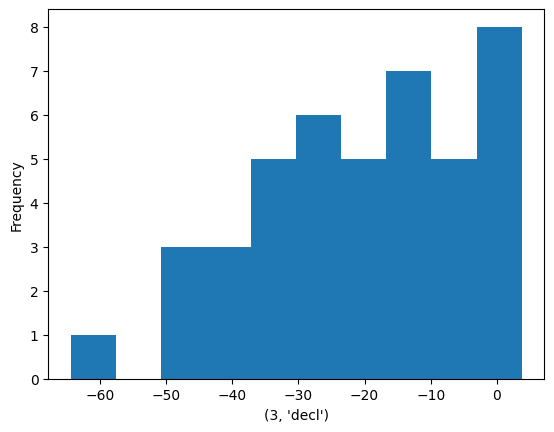

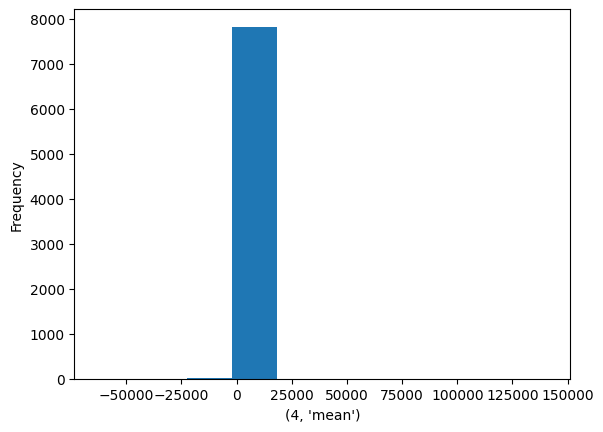

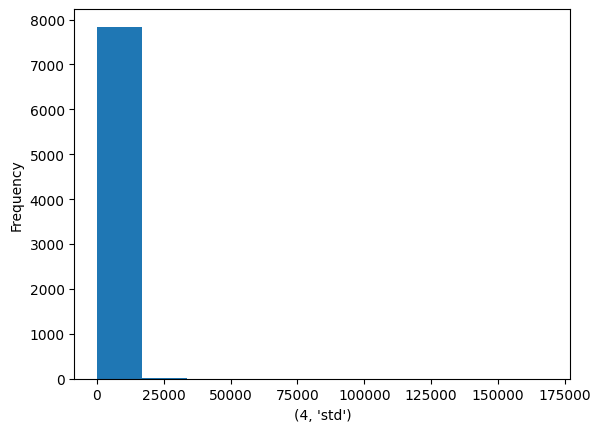

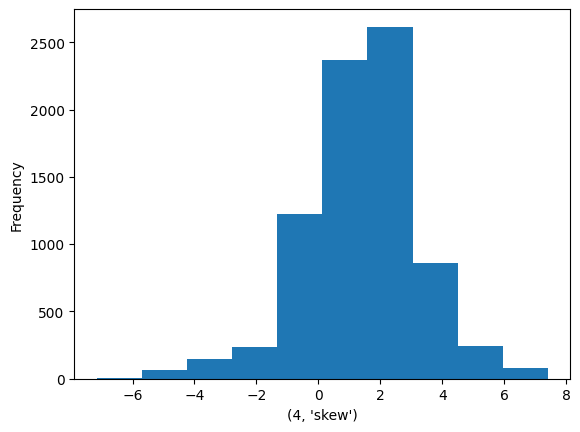

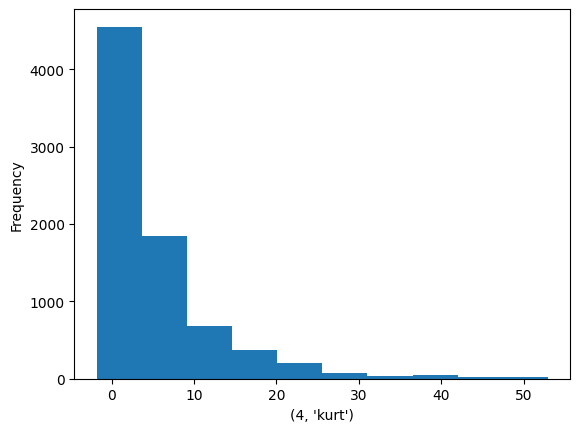

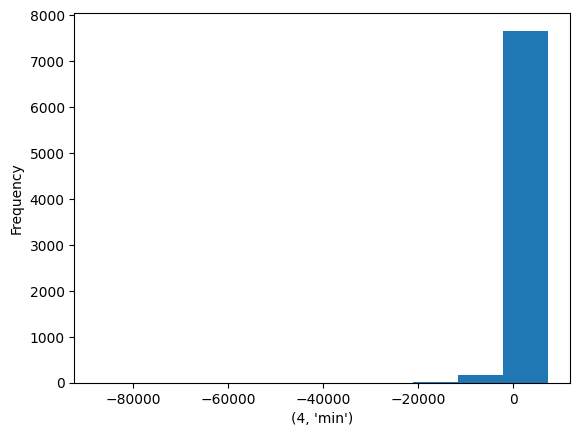

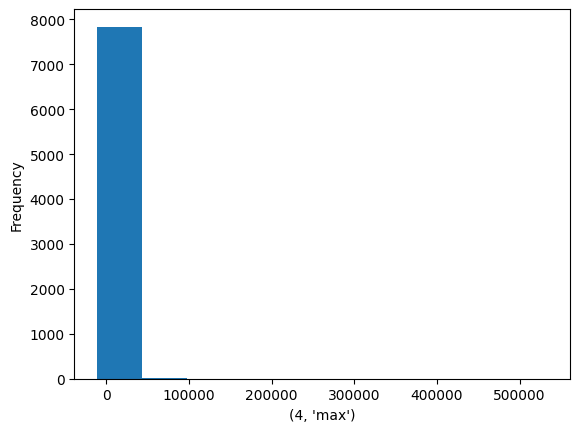

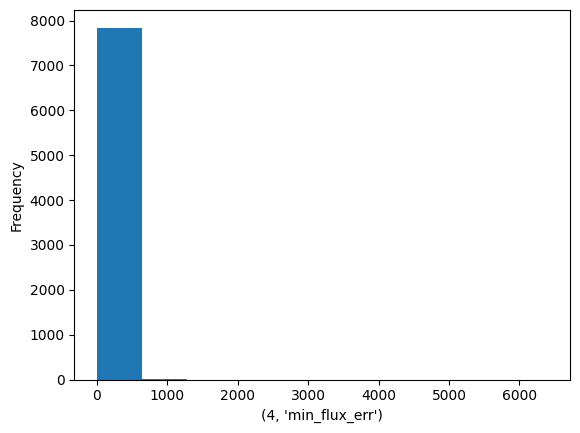

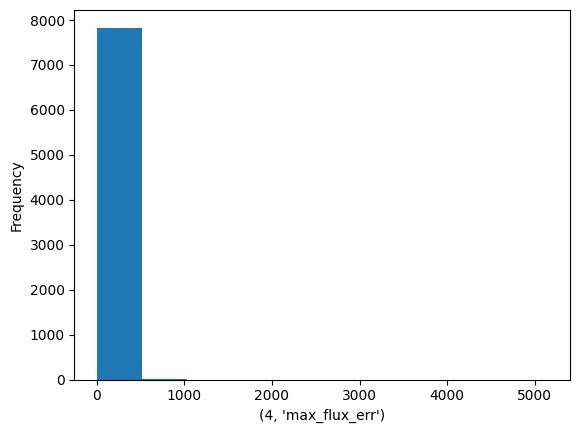

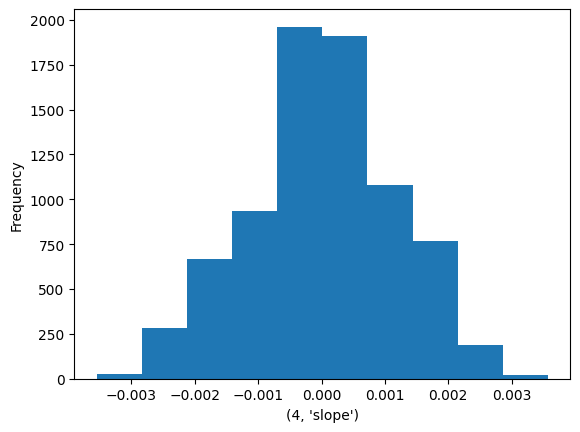

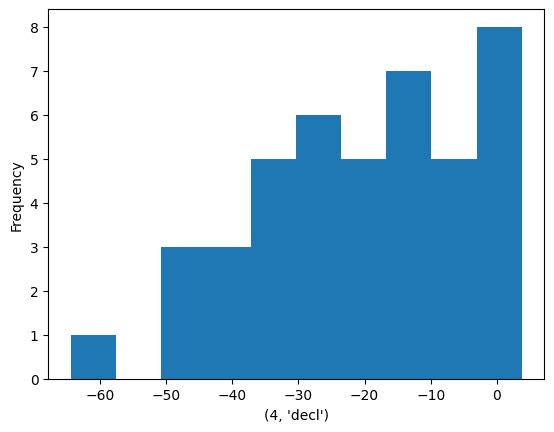

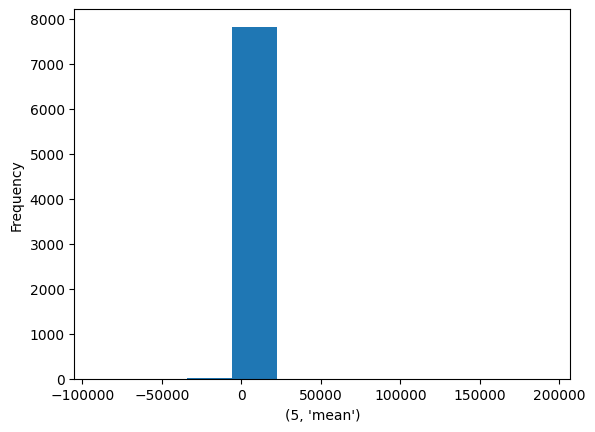

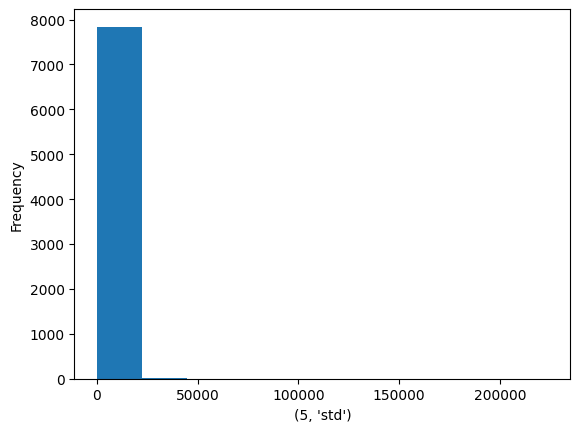

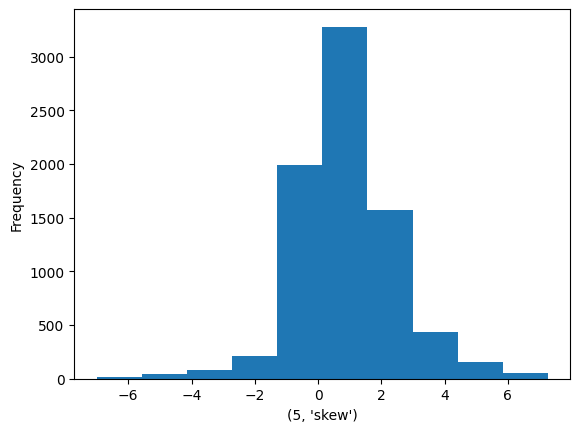

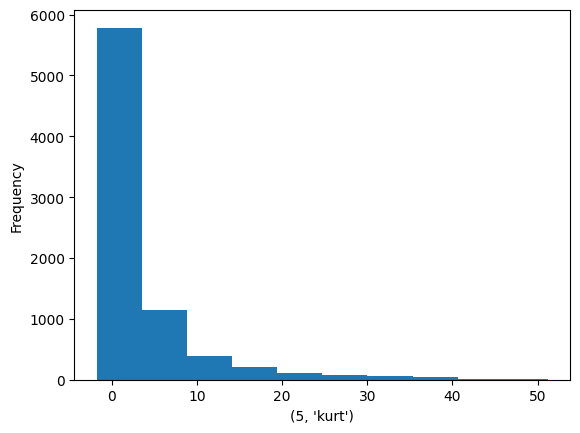

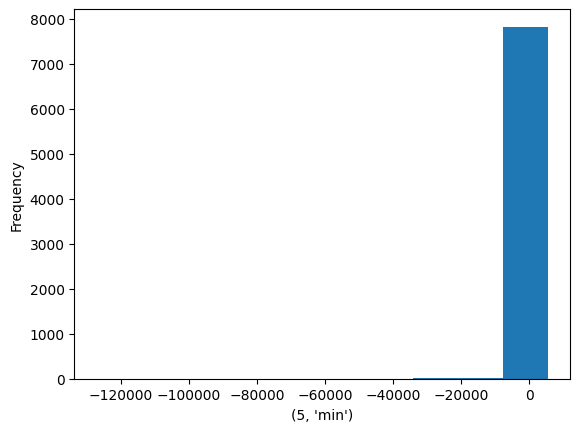

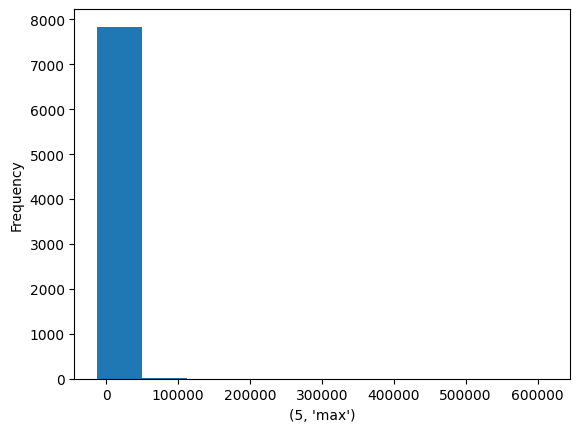

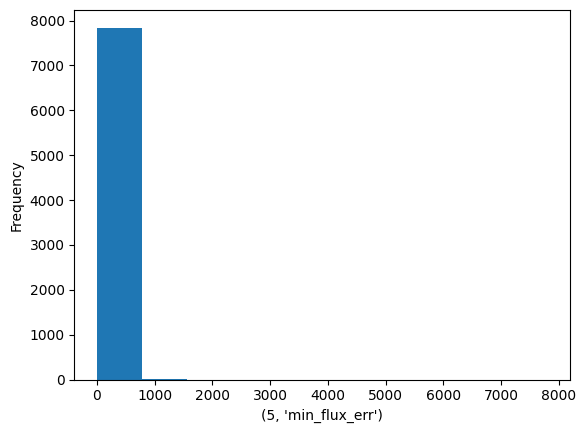

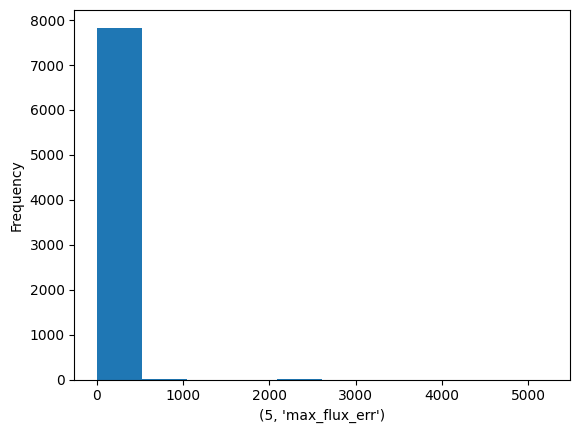

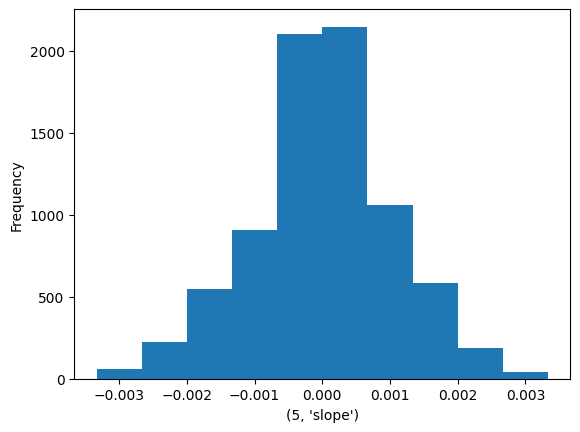

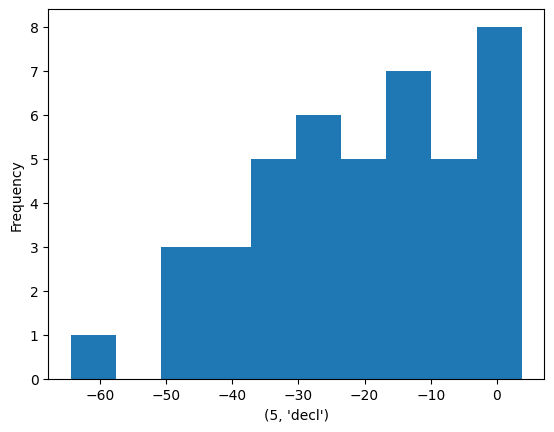

In [129]:
for i in allfeatures.columns:

  if i[1] == "index" or i[0] == "index":
    continue

  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')


# TASK III : Gaussian Processes

Take the time series and fit them with GPs.
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb)

- make sure you use the standardized time series : before you fit the GP to it each time series shoud be made to be mean 0 and standard deviation 1 (note - mean across all time stamps! not across all lightcurves). YOu can just do it by hand as lc /= lc.mean() or you can use `sklearn.preprocessing.StandardScaler`

- make sure you process the uncertainty as well as the data in the standardization! (divide by the same constant the lighcruve fluxes and its uncertaities)

- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)

- take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata `target` variable

- fit the GP kernerl to each time series band by band

- collect the best fit parameters and describe their variance (across the 10 time series) `gp.get_parameter_vector()` - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?



In [130]:
!pip install george

In [131]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern, ExpSineSquared
from sklearn.preprocessing import StandardScaler
from george import kernels
import george

In [132]:
# prompt: use Standard Scaler to standardize  the flux and flux error lcvs_scaled across all time stamps

# Use StandardScaler to standardize 'flux_scaled' and 'flux_err_scaled' across all timestamps.

scaler = StandardScaler()

lcvs_scaled[['flux_scaled', 'flux_err_scaled']] = scaler.fit_transform(lcvs_scaled[['flux_scaled', 'flux_err_scaled']])
lcvs_scaled.head()

object_id         mjd  passband  flux_scaled  flux_err_scaled
0        615  59750.4229         2    -0.910198         0.422316
1        615  59750.4306         1    -0.722010         0.452984
2        615  59750.4383         3    -1.053414         1.338867
3        615  59750.4450         4    -1.151251         7.037395
4        615  59752.4070         2    -1.213953         1.150246

In [133]:
#Preprocessing the data for mean 0 and sd 1
#lcvs_scaled = lcvs_scaled.groupby(['object_id', 'passband']).apply(lambda x: (x - x.mean()) / x.std())
lcvs_scaled.head()

object_id         mjd  passband  flux_scaled  flux_err_scaled
0        615  59750.4229         2    -0.910198         0.422316
1        615  59750.4306         1    -0.722010         0.452984
2        615  59750.4383         3    -1.053414         1.338867
3        615  59750.4450         4    -1.151251         7.037395
4        615  59752.4070         2    -1.213953         1.150246

In [134]:
lcvs_scaled["flux_scaled"].mean()
lcvs_scaled["flux_scaled"].std()

lcvs_scaled["flux_err_scaled"].mean()
#lcvs_scaled["flux_err_scaled"].std()

1.163242879135709e-18

take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata target variable

fit the GP kernerl to each time series band by band

collect the best fit parameters and describe their variance (across the 10 time series) gp.get_parameter_vector() - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?

In [135]:
# prompt: I need a time prediction space to use for fitting gaussian process to my data

import numpy as np
# Create a time prediction space
min_time = lcvs_scaled['mjd'].min()
max_time = lcvs_scaled['mjd'].max()
t_pred = np.linspace(min_time, max_time, 500) # Adjust the number of points as needed
t_pred

array([59580.0343    , 59582.22734349, 59584.42038697, 59586.61343046,
       59588.80647395, 59590.99951743, 59593.19256092, 59595.38560441,
       59597.5786479 , 59599.77169138, 59601.96473487, 59604.15777836,
       59606.35082184, 59608.54386533, 59610.73690882, 59612.9299523 ,
       59615.12299579, 59617.31603928, 59619.50908277, 59621.70212625,
       59623.89516974, 59626.08821323, 59628.28125671, 59630.4743002 ,
       59632.66734369, 59634.86038717, 59637.05343066, 59639.24647415,
       59641.43951764, 59643.63256112, 59645.82560461, 59648.0186481 ,
       59650.21169158, 59652.40473507, 59654.59777856, 59656.79082204,
       59658.98386553, 59661.17690902, 59663.36995251, 59665.56299599,
       59667.75603948, 59669.94908297, 59672.14212645, 59674.33516994,
       59676.52821343, 59678.72125691, 59680.9143004 , 59683.10734389,
       59685.30038737, 59687.49343086, 59689.68647435, 59691.87951784,
       59694.07256132, 59696.26560481, 59698.4586483 , 59700.65169178,
      

In [136]:

# Assuming lcvs_scaled and metadata DataFrames are already loaded and processed.

# Select 10 unique object IDs with different target values
unique_targets = metadata['target'].unique()[:10]  # Select the first 10 unique targets
selected_object_ids = []
for target in unique_targets:
    object_id = metadata[metadata['target'] == target]['object_id'].iloc[0]
    selected_object_ids.append(object_id)

# Filter the light curves data for selected objects
selected_lcvs = lcvs_scaled[lcvs_scaled['object_id'].isin(selected_object_ids)]

# Fit a GP to each time series (band by band)
params = pd.DataFrame(columns=['obj_id', 'param1', 'param2', 'param3'])
for object_id in selected_object_ids:
    for passband in selected_lcvs["passband"].unique():
        # Get data for the specific object and passband
        subset = selected_lcvs[(selected_lcvs['object_id'] == object_id) & (selected_lcvs['passband'] == passband)]
        x = subset['mjd'].values
        y = subset['flux_scaled'].values
        yerr = subset['flux_err_scaled'].values

        # Define the kernel
        kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5),
                                     kernels.CosineKernel(1))



        # Initialize the GP
        gp = george.GP(kernel)

        # Try to fit the GP (error handling)


        #try:
        gp.compute(x, yerr)
        gp.predict(y, t_pred, return_var=True)
        params = pd.concat([params, pd.DataFrame([[object_id, *gp.get_parameter_vector()]], columns=['obj_id','param1', 'param2', 'param3'])])
        '''
        except Exception as e:
            print(f"Object {object_id}, Passband {passband}: Error fitting GP: {e}")
            continue
        '''
            #gp.optimize(x,y)


params

<ipython-input-136-5d92cb2d8c26>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params = pd.concat([params, pd.DataFrame([[object_id, *gp.get_parameter_vector()]], columns=['obj_id','param1', 'param2', 'param3'])])


obj_id        param1    param2  param3
0    615 -2.220446e-16 -0.693147     1.0
0    615  2.220446e-16 -0.693147     1.0
0    615  2.220446e-16 -0.693147     1.0
0    615  0.000000e+00 -0.693147     1.0
0    615 -1.110223e-16 -0.693147     1.0
0    615  2.220446e-16 -0.693147     1.0
0    713  0.000000e+00 -0.693147     1.0
0    713  2.220446e-16 -0.693147     1.0
0    713  0.000000e+00 -0.693147     1.0
0    713 -3.330669e-16 -0.693147     1.0
0    713  0.000000e+00 -0.693147     1.0
0    713 -2.220446e-16 -0.693147     1.0
0    730  0.000000e+00 -0.693147     1.0
0    730 -1.110223e-16 -0.693147     1.0
0    730  0.000000e+00 -0.693147     1.0
0    730  0.000000e+00 -0.693147     1.0
0    730  0.000000e+00 -0.693147     1.0
0    730  0.000000e+00 -0.693147     1.0
0    745 -2.220446e-16 -0.693147     1.0
0    745  0.000000e+00 -0.693147     1.0
0    745  0.000000e+00 -0.693147     1.0
0    745  0.000000e+00 -0.693147     1.0
0    745  0.000000e+00 -0.693147     1.0
0    745 -2.220446e-16 -0.693147     1.0
0   1227  2.220446e-16 -0.693147     1.0
0   1227  0.000000e+00 -0.693147     1.0
0   1227 -1.110223e-16 -0.693147     1.0
0   1227  2.220446e-16 -0.693147     1.0
0   1227  2.220446e-16 -0.693147     1.0
0   1227  4.440892e-16 -0.693147     1.0
0   2677  2.220446e-16 -0.693147     1.0
0   2677 -2.220446e-16 -0.693147     1.0
0   2677  2.220446e-16 -0.693147     1.0
0   2677 -1.110223e-16 -0.693147     1.0
0   2677  0.000000e+00 -0.693147     1.0
0   2677 -2.220446e-16 -0.693147     1.0
0   2922  2.220446e-16 -0.693147     1.0
0   2922 -3.330669e-16 -0.693147     1.0
0   2922  0.000000e+00 -0.693147     1.0
0   2922  0.000000e+00 -0.693147     1.0
0   2922 -2.220446e-16 -0.693147     1.0
0   2922 -2.220446e-16 -0.693147     1.0
0   3423 -1.110223e-16 -0.693147     1.0
0   3423  0.000000e+00 -0.693147     1.0
0   3423  2.220446e-16 -0.693147     1.0
0   3423  2.220446e-16 -0.693147     1.0
0   3423 -2.220446e-16 -0.693147     1.0
0   3423  2.220446e-16 -0.693147     1.0
0   3910  0.000000e+00 -0.693147     1.0
0   3910  0.000000e+00 -0.693147     1.0
0   3910  0.000000e+00 -0.693147     1.0
0   3910  0.000000e+00 -0.693147     1.0
0   3910  2.220446e-16 -0.693147     1.0
0   3910  2.220446e-16 -0.693147     1.0
0   4173  0.000000e+00 -0.693147     1.0
0   4173 -1.110223e-16 -0.693147     1.0
0   4173  2.220446e-16 -0.693147     1.0
0   4173  2.220446e-16 -0.693147     1.0
0   4173 -1.110223e-16 -0.693147     1.0
0   4173  2.220446e-16 -0.693147     1.0

collect the best fit parameters and describe their variance (across the 10 time series) gp.get_parameter_vector() - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?

In [137]:
params.shape

(60, 4)

In [138]:
# prompt: get the variance of both parameters for each object

# Calculate variance of parameters for each object
param_variance = params.groupby('obj_id').var()
param_variance

param1  param2  param3
obj_id                              
615     3.821045e-32     0.0     0.0
713     3.821045e-32     0.0     0.0
730     2.054325e-33     0.0     0.0
745     1.314768e-32     0.0     0.0
1227    3.821045e-32     0.0     0.0
2677    4.149737e-32     0.0     0.0
2922    4.149737e-32     0.0     0.0
3423    3.821045e-32     0.0     0.0
3910    1.314768e-32     0.0     0.0
4173    2.793882e-32     0.0     0.0

The variance appears to be near zero across all parameters. This means that the parameter values are not deviating too far from the mean. Thus, we could take the mean of each parameter (keeping the constant value for the constant ones) and use that to initialize the fit for the whole dataset.

# CHALLENGE (Extra Credit): fit the 2D time series:
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series.
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)